In [9]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [10]:
api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
tags = ["2024-05-04-17-07-48", "2024-05-04-17-48-13"]
filters = {"tags": {"$in": tags}, "state": "finished"}
runs = api.runs(entity + "/" + project, filters=filters)
runs


<Runs ajzero/AlphaZero>

In [23]:
data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

# filter out runs with Evaluation/Mean_Returns == -100
# df = df[df['Evaluation/Mean_Returns'] != 0]

ncols, nrows = df["ncols"][0], 4
df

100%|██████████| 120/120 [00:00<00:00, 121456.68it/s]


,Self_Play/Total_Mean_Discounted_Return,Training/Policy_loss,Evaluation/Discounted_Returns,Evaluation/Mean_Returns,_runtime,grad_steps,Evaluation/Entropies,Training/Replay_Buffer_Size,Self_Play/EMA_Discounted_Return,Self_Play/Timesteps,...,policy_loss_weight,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform
0,0.533138,1.016405,"{'bins': [0.09048992395401001, 0.1061149239540...",1,247.462105,58,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",90,0.564499,"{'_type': 'histogram', 'bins': [6, 6.03125, 6....",...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity
1,0.279330,0.894785,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...",1,670.347410,58,"{'bins': [0.027875423431396484, 0.043500423431...",90,0.522484,"{'_type': 'histogram', 'bins': [6, 6.09375, 6....",...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
2,0.242514,0.983982,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,334.736241,58,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",90,0.334746,"{'bins': [5, 5.078125, 5.15625, 5.234375, 5.31...",...,0.3,4,identity,coordinate,0.000001,PUCT,6,visit,15,identity
3,0.433303,0.895261,"{'_type': 'histogram', 'bins': [0.090489923954...",1,236.308056,58,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...",90,0.556082,"{'_type': 'histogram', 'values': [5, 0, 0, 0, ...",...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity
4,0.328284,1.059390,"{'_type': 'histogram', 'bins': [0.090489923954...",1,279.915872,58,"{'_type': 'histogram', 'bins': [-0.15567639470...",90,0.487306,"{'values': [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0...",...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.210298,1.093707,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,332.703290,58,"{'_type': 'histogram', 'bins': [-0.04924747347...",90,0.381506,"{'values': [2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0...",...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
116,-0.173268,1.253850,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",0,67.818959,58,"{'bins': [0.4137696623802185, 0.42939466238021...",90,-0.034456,"{'bins': [7, 7.140625, 7.28125, 7.421875, 7.56...",...,0.3,4,identity,coordinate,0.000001,PUCT,6,visit,15,identity
117,0.086283,1.165145,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...",0,268.893031,58,"{'_type': 'histogram', 'bins': [0.382469236850...",90,0.201187,"{'bins': [13, 14.359375, 15.71875, 17.078125, ...",...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity
118,0.102226,1.244834,"{'bins': [0.09048992395401001, 0.1061149239540...",1,621.773460,58,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",90,0.256133,"{'_type': 'histogram', 'bins': [9, 9.234375, 9...",...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity


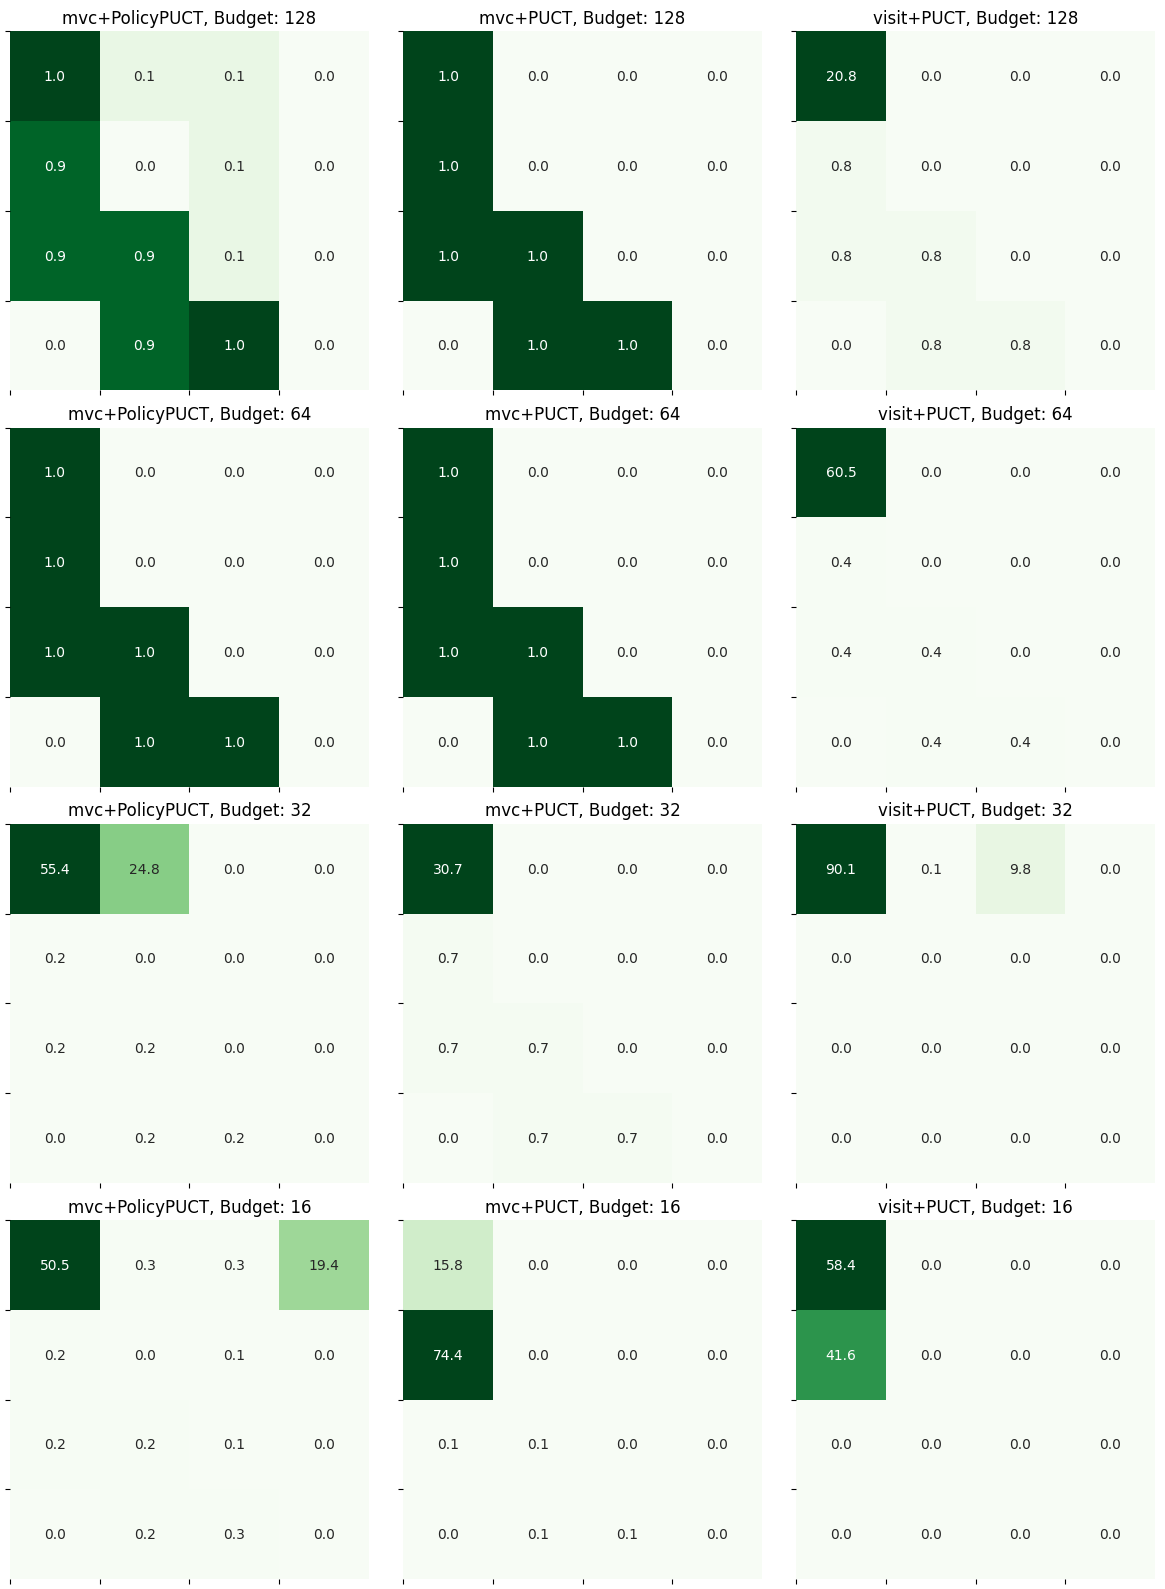

In [27]:
# filter out 128 planning budget
# Assuming 'df' is your DataFrame
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

# Group the DataFrame by both 'policy_combination' and 'planning_budget'
grouped = df.groupby(['policy_combination', 'planning_budget'])['Evaluation/Trajectories']


# Aggregate the trajectories lists within each group
aggregated_trajectories = grouped.sum()

# Define functions to calculate coordinates and density
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(trajectories, ncols, nrows):
    density = np.zeros((nrows, ncols))
    for trajectory in trajectories:
        for state in trajectory:
            row, col = obs_to_cords(state, ncols)
            density[row, col] += 1
    return density

# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
    ax = axs[i][j] if n_budgets > 1 and n_policies > 1 else axs[max(i, j)]
    sns.heatmap(density, ax=ax, cmap='Greens', cbar=False, annot=True, fmt='.1f')
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square
    # set subtitle
    ax.set_title(f"{policy_combination}, Budget: {planning_budget}")



plt.tight_layout()
plt.savefig("outfiles/4x4lake_training_dist.pdf")
plt.show()


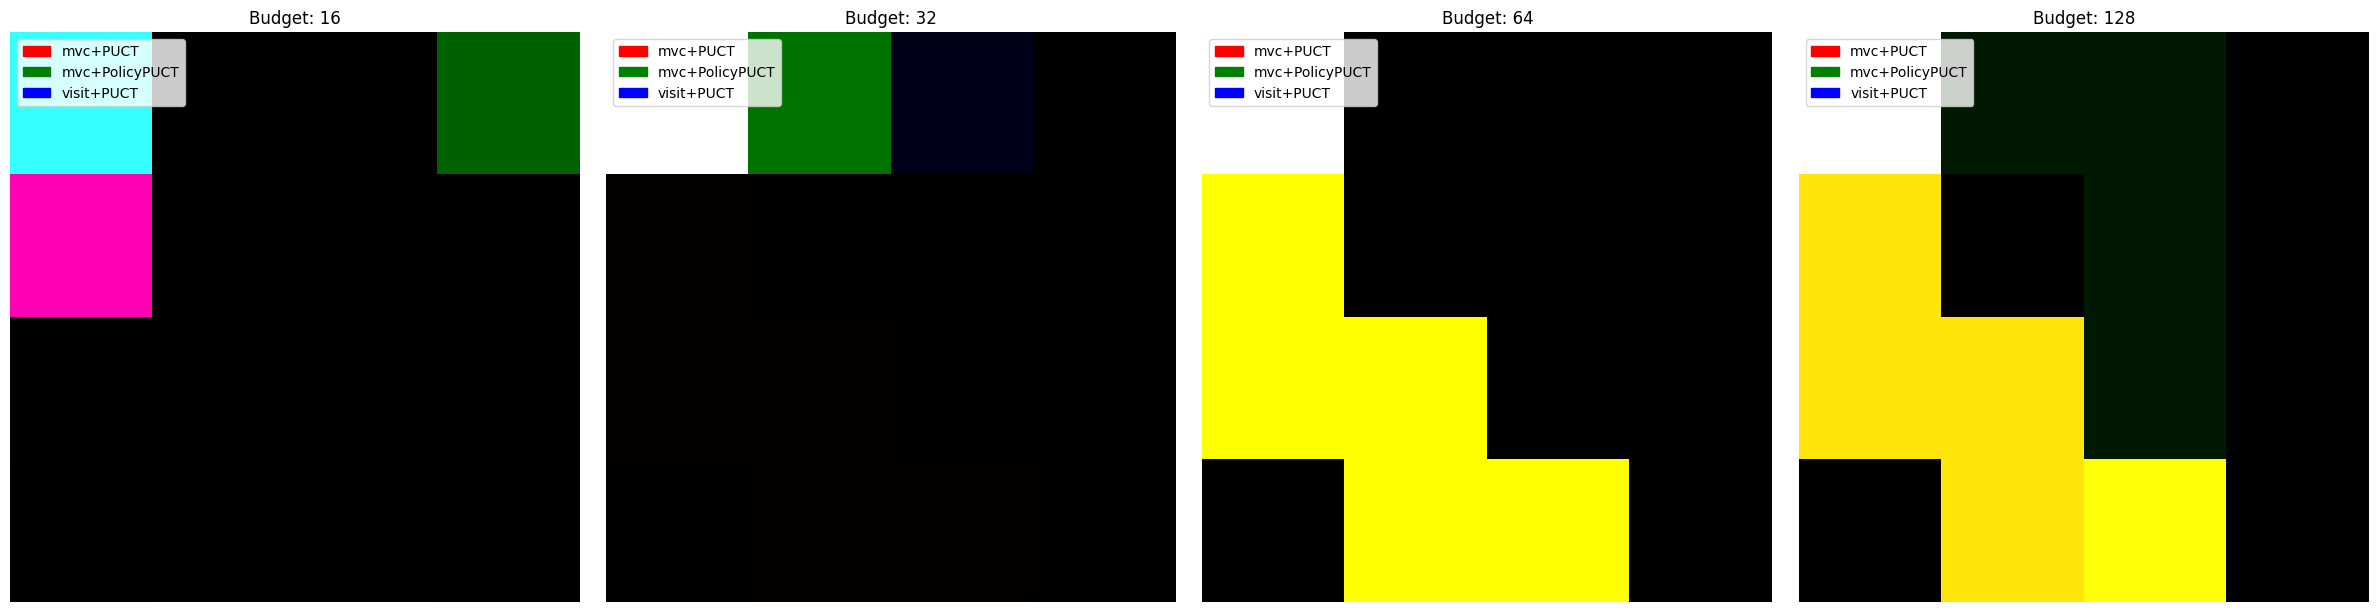

In [25]:
import matplotlib.patches as mpatches
grouped = df.groupby(['planning_budget', 'policy_combination'])['Evaluation/Trajectories'].sum()


# Determine the number of unique planning budgets
n_budgets = len(grouped.index.get_level_values(0).unique())

# Prepare a single figure with multiple subplots (one for each planning_budget)
fig, axs = plt.subplots(1, n_budgets, figsize=(6 * n_budgets, 6))

# Iterate over each planning_budget and create RGB heatmaps
for idx, (planning_budget, budget_group) in enumerate(grouped.groupby(level=0)):
    rgb_image = np.zeros((nrows, ncols, 3))  # Initialize RGB layers
    colors = ['Red', 'Green', 'Blue']  # Map trajos keys to RGB channels
    channel_colors = {name: color for name, color in zip(budget_group.index.get_level_values(1), colors)}

    # Compute density for each policy combination and assign to RGB channels
    for jdx, ((_, policy_combination), trajectories) in enumerate(budget_group.items()):
        density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
        norm_density = density / np.max(density, where=(density!=0), initial=1)  # Normalize avoiding division by zero
        rgb_image[:, :, jdx % 3] += norm_density  # Accumulate in RGB layers, repeating colors if more than 3 policies

    ax = axs[idx] if n_budgets > 1 else axs
    ax.imshow(rgb_image, aspect='equal')
    ax.axis('off')  # Hide grid lines and labels

    # Create a legend
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in channel_colors.items()]
    ax.legend(handles=legend_patches, loc='upper left')
    ax.set_title(f"Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/dist_training_cliff_rgb.pdf")
plt.show()